In [2]:
# https://gist.github.com/ferrouswheel/4e9d9b793bfc5a8d043d

In [3]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

user = os.environ.get('DB_USERNAME')
pwd = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOSTNAME')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
engine = create_engine(url)

In [3]:
sql = '''SELECT table_name
  FROM information_schema.tables
 WHERE table_schema='public'
   AND table_type='BASE TABLE';'''

tables = pd.read_sql(sql, engine).table_name

print(tables)

0                       spatial_ref_sys
1                             opennames
2                            openrivers
3                             openroads
4                          boundaryline
5                          openmaplocal
6                        opengreenspace
7                              openuprn
8                              opentoid
9     boundary_line_ceremonial_counties
10      boundary_line_historic_counties
11                       community_ward
12                               county
13            county_electoral_division
14             district_borough_unitary
15        district_borough_unitary_ward
16                       english_region
17                 greater_london_const
18                           high_water
19             historic_european_region
20                               parish
21            polling_districts_england
22             scotland_and_wales_const
23            scotland_and_wales_region
24           unitary_electoral_division


In [6]:
buffer=400
x=338286
y=392077

In [10]:
def pgselect(table, buffer=400, x=338286, y=392077):
    user = os.environ.get('DB_USERNAME')
    pwd = os.environ.get('DB_PASSWORD')
    host = os.environ.get('DB_HOSTNAME')
    port = os.environ.get('DB_PORT')

    url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
    engine = create_engine(url)
    sql = f'SELECT * FROM {table} WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'
    return gpd.read_postgis(sql, engine, geom_col='geometry')

In [9]:
uprn = pgselect('openuprn', 100)

In [8]:
roads = pgselect('openroads', 100)

In [10]:
roads.columns

Index(['id', 'endNode', 'startNode', 'roadNumberTOID', 'roadNameTOID',
       'fictitious', 'roadClassification', 'roadFunction', 'formOfWay',
       'length', 'length_uom', 'loop', 'primaryRoute', 'trunkRoad',
       'roadClassificationNumber', 'name1', 'name1_lang', 'name2',
       'name2_lang', 'roadStructure', 'geometry'],
      dtype='object')

In [11]:
uprn.columns

Index(['UPRN', 'X_COORDINATE', 'Y_COORDINATE', 'LATITUDE', 'LONGITUDE',
       'geometry'],
      dtype='object')

In [12]:
uprn

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,geometry
0,38020670,338380.00,392058.00,53.421719,-2.928698,POINT (338380.000 392058.000)
1,38020674,338376.00,392057.00,53.421710,-2.928758,POINT (338376.000 392057.000)
2,38020675,338371.00,392057.00,53.421709,-2.928834,POINT (338371.000 392057.000)
3,38020676,338367.00,392057.00,53.421709,-2.928894,POINT (338367.000 392057.000)
4,38020677,338362.00,392056.00,53.421699,-2.928969,POINT (338362.000 392056.000)
...,...,...,...,...,...,...
152,38335888,338263.41,392127.51,53.422330,-2.930466,POINT (338263.410 392127.510)
153,38335889,338264.07,392123.22,53.422292,-2.930455,POINT (338264.070 392123.220)
154,38335890,338264.46,392118.02,53.422245,-2.930449,POINT (338264.460 392118.020)
155,38335891,338262.86,392137.35,53.422419,-2.930477,POINT (338262.860 392137.350)


In [13]:
sql = '''
SELECT id, geometry FROM openroads
'''

In [14]:
roadids = gpd.read_postgis(sql, engine, geom_col='geometry')

In [17]:
bulk_nn_query = '''
SELECT
  parcels.*,
  hydrants.cartodb_id as hydrant_cartodb_id,
  ST_Distance(geography(hydrants.the_geom), geography(parcels.the_geom)) AS distance
FROM
  parcelsshp AS parcels
CROSS JOIN LATERAL
  (SELECT cartodb_id, the_geom
   FROM hydrantsshp
   ORDER BY
     parcels.the_geom_webmercator <-> the_geom_webmercator
   LIMIT 1) AS hydrants
''' #https://carto.com/blog/lateral-joins/

In [18]:
# tables parcelsshp and hydrants

In [7]:
sql2 = f'''
SELECT 
 openroads.id as road_id,
 openroads.geometry as road_geometry,
 nearest.UPRN as uprn,
 nearest.geometry as uprn_geometry
FROM openroads WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})
CROSS JOIN LATERAL
 (SELECT *
 FROM openuprn WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})
 ORDER BY
 openroads.geometry <-> openuprn.geometry
 LIMIT 1) AS nearest
'''

In [8]:
sql = f'''
SELECT *
FROM openroads WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})
CROSS JOIN LATERAL
 (SELECT *
 FROM openuprn WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})
 ORDER BY
 openroads.geometry <-> geometry
 LIMIT 1) AS nearest
'''

In [9]:
try:
    df = pd.read_sql(sql, engine)
except Exception as e:
    print(e)
    gdf = gpd.read_postgis(sql2, engine, geom_col='geometry')

(psycopg2.errors.SyntaxError) syntax error at or near "CROSS"
LINE 4: CROSS JOIN LATERAL
        ^

[SQL: 
SELECT *
FROM openroads WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point(338286, 392077), 27700), 400)
CROSS JOIN LATERAL
 (SELECT *
 FROM openuprn WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point(338286, 392077), 27700), 400)
 ORDER BY
 openroads.geometry <-> geometry
 LIMIT 1) AS nearest
]
(Background on this error at: http://sqlalche.me/e/13/f405)


ProgrammingError: (psycopg2.errors.SyntaxError) syntax error at or near "CROSS"
LINE 8: CROSS JOIN LATERAL
        ^

[SQL: 
SELECT 
 openroads.id as road_id,
 openroads.geometry as road_geometry,
 nearest.UPRN as uprn,
 nearest.geometry as uprn_geometry
FROM openroads WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point(338286, 392077), 27700), 400)
CROSS JOIN LATERAL
 (SELECT *
 FROM openuprn WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point(338286, 392077), 27700), 400)
 ORDER BY
 openroads.geometry <-> openuprn.geometry
 LIMIT 1) AS nearest
]
(Background on this error at: http://sqlalche.me/e/13/f405)

In [ ]:
df.head()

In [ ]:
bulknn = gpd.read_postgis(sql, engine, geom_col='')

In [11]:
roads = pgselect('openroads')

In [13]:
points = pgselect('openuprn')

In [15]:
len(roads)

136

In [16]:
len(points)

1518

In [19]:
from shapely.ops import nearest_points

In [ ]:
# for each point,
# find nearest street

# https://stackoverflow.com/questions/62198199/k-nearest-points-from-two-dataframes-with-geopandas

In [20]:
from sklearn.neighbors import BallTree
import numpy as np

def get_nearest(src_points, candidates, k_neighbors=2):
    """
    Find nearest neighbors for all source points from a set of candidate points
    modified from: https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html
    """
    

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]
    closest_second = indices[1] # *manually add per comment above*
    closest_second_dist = distances[1] # *manually add per comment above*

    # Return indices and distances
    return (closest, closest_dist, closest_sec, closest_sec_dist)

In [23]:
# easier to read
in_pts = [(row.geometry.x, row.geometry.y) for idx, row in gdf1.iterrows()]
qry_pts = [(row.geometry.x, row.geometry.y) for idx, row in gdf2.iterrows()]

# faster (by about 7X)
in_pts = [(x,y) for x,y in zip(gdf1.geometry.x , gdf1.geometry.y)]
qry_pts =  [(x,y) for x,y in zip(gdf2.geometry.x , gdf2.geometry.y)]

AttributeError: 'LineString' object has no attribute 'x'

In [22]:
gdf1 = roads
gdf2 = points

In [24]:
# https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html

In [35]:
nearest_points(points.geometry[0],list(roads.geometry.values))

AttributeError: 'list' object has no attribute '_geom'

In [41]:
pt_list = list(points.geometry.values)

In [42]:
rd_list = list(roads.geometry.values)

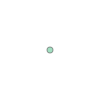

In [75]:
points.iloc[0].geometry

In [107]:
def closest_road(pt_row):
    rd_df= roads
    # for each points row
    # get point id
    pt_it = pt_row.UPRN
    # get distance to all roads,
    dfdict = dict()
    for i in range(len(roads)):
        rd_row = roads.iloc[i]
        dfdict[i] = dict()
        dfdict[i]['rd_id'] = rd_row.id
        dfdict[i]['distance'] = pt_row.geometry.distance(rd_row.geometry)
    return pd.DataFrame(dfdict).T.sort_values('distance').iloc[0].values[0]

In [109]:
 closest_road(points.iloc[0])

'id18D3DE2B-A590-4310-BD30-9817660D4DFB'

In [112]:
points[['nearest_rd']]=points.apply(closest_road,axis=1)

In [121]:
d = pd.DataFrame(points[['UPRN','nearest_rd']].groupby('nearest_rd'))

In [127]:
len(roads)

136

In [128]:
len(points)

1518

In [130]:
roads['color'] = roads.index

In [144]:
mapper = {d[1]:d[0] for d in dict(roads.id.T).items()}

In [146]:
points['color'] = points.nearest_rd.apply(lambda x: mapper[x])

<AxesSubplot:>

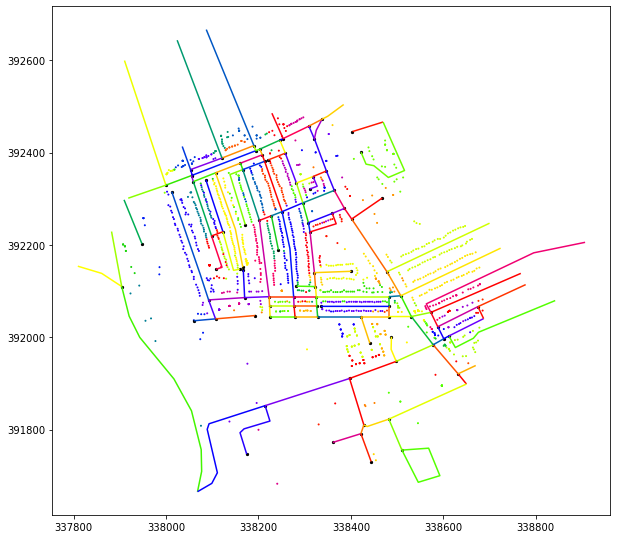

In [163]:
fig, ax = plt.subplots(figsize=(10,10))
cmap = 'prism`'
roads.plot('color', ax=ax, cmap=cmap)
points.plot('color', ax=ax, markersize=1, cmap=cmap)
nodes.plot(ax=ax, markersize=5, color='k')

In [80]:
pt_id, rd_id, distance

In [80]:
for i in range(len(roads)):
    rd = roads.iloc[i]
#     print(i, rd.id)

In [54]:
nodes = pgselect('roadnodes')

In [56]:
nodes.formOfRoadNode.unique()

array(['junction', 'road end', 'pseudo node'], dtype=object)

98

In [62]:
roads.loc[98]

id                                     id18D3DE2B-A590-4310-BD30-9817660D4DFB
endNode                                idA007397F-6F4A-459F-89A0-85E5F131A861
startNode                              id431A58A5-C76D-4B18-96E7-9888C4C91A3F
roadNumberTOID                                                           None
roadNameTOID                                             osgb4000000013356115
fictitious                                                              False
roadClassification                                               Unclassified
roadFunction                                                       Local Road
formOfWay                                                  Single Carriageway
length                                                                     73
length_uom                                                                  m
loop                                                                    False
primaryRoute                                                    

In [70]:
buildings = pgselect('openmaplocal')

In [70]:
buildings

<AxesSubplot:>

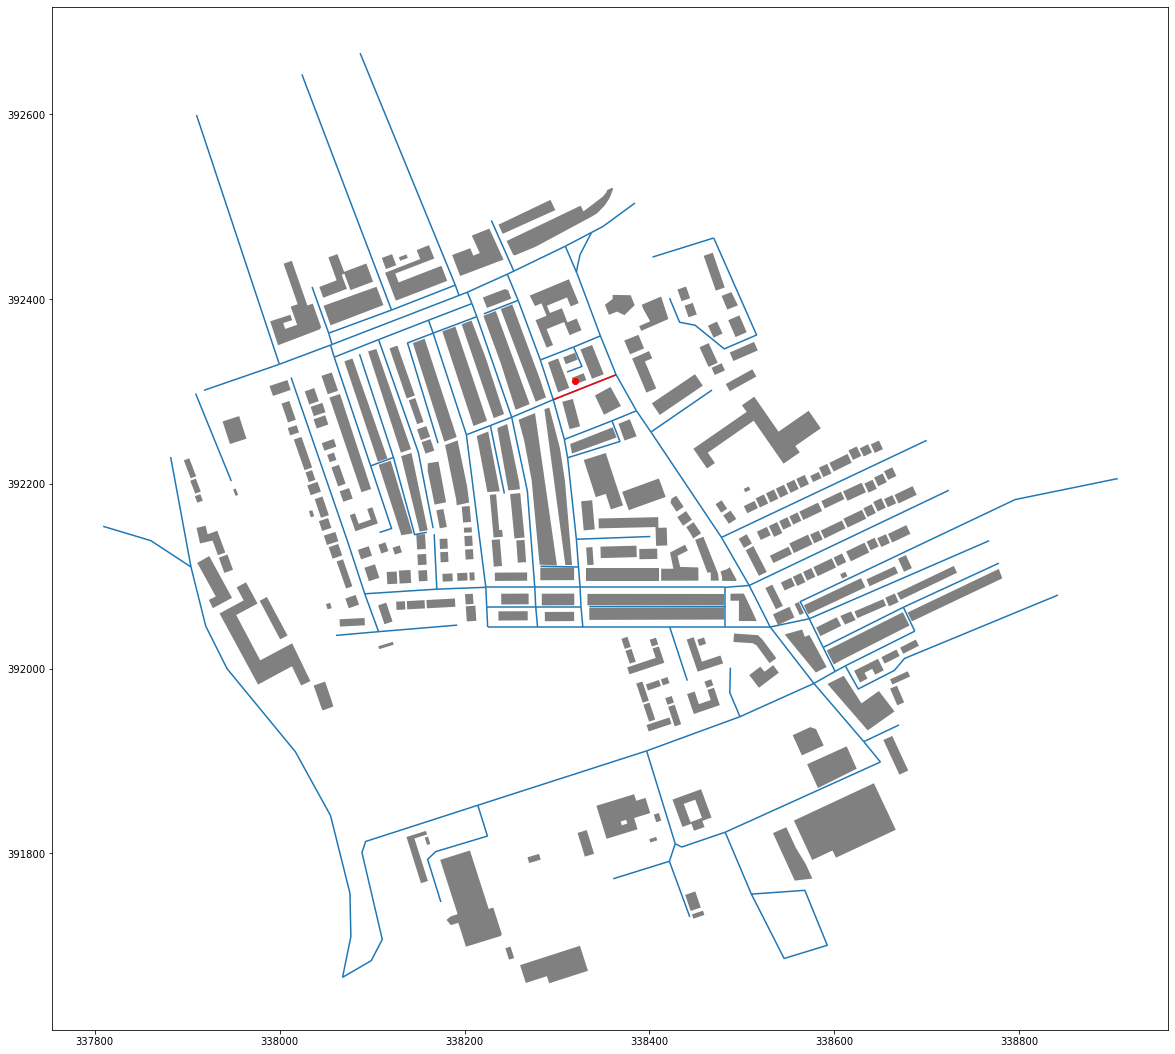

In [73]:
fig, ax = plt.subplots(figsize=(20,20))
roads.plot(ax=ax)
buildings.plot(ax=ax, color='gray')
#points.plot(ax=ax)
roads.iloc[98:99].plot(ax=ax, color='red')
points.iloc[:1].plot(ax=ax, color='red')